In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
import tensorflow.keras as keras

#from utils import get_kaggle_dataset, organize_face_mask_dataset
from utils.utils import get_kaggle_dataset, organize_face_mask_dataset
from utils.plotting import HistoryPlotter

In [2]:
SEED = 42
BATCH_SIZE = 128
IMAGE_SIZE = [150,150]
KAGGLE_DATASET = "ashishjangra27/face-mask-12k-images-dataset"
DATASET_PATH = "~/Downloads/datasets/"

np.random.seed(SEED)

In [3]:
get_kaggle_dataset(KAGGLE_DATASET, DATASET_PATH)
organize_face_mask_dataset(os.path.join(DATASET_PATH, KAGGLE_DATASET.split('/')[1]))

Download Complete
Files Organized


In [3]:
mask_ds_path = os.path.join(os.path.expanduser(DATASET_PATH), KAGGLE_DATASET.split('/')[1])

train_ds = keras.preprocessing.image_dataset_from_directory(mask_ds_path,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=SEED,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE
                                                            )
validation_ds = keras.preprocessing.image_dataset_from_directory(mask_ds_path,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=SEED,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE
                                                            )

# take 5 batches for test_ds, rest for validation_ds
test_ds = validation_ds.take(5)
validation_ds = validation_ds.skip(5)

Found 11792 files belonging to 2 classes.
Using 9434 files for training.
Found 11792 files belonging to 2 classes.
Using 2358 files for validation.


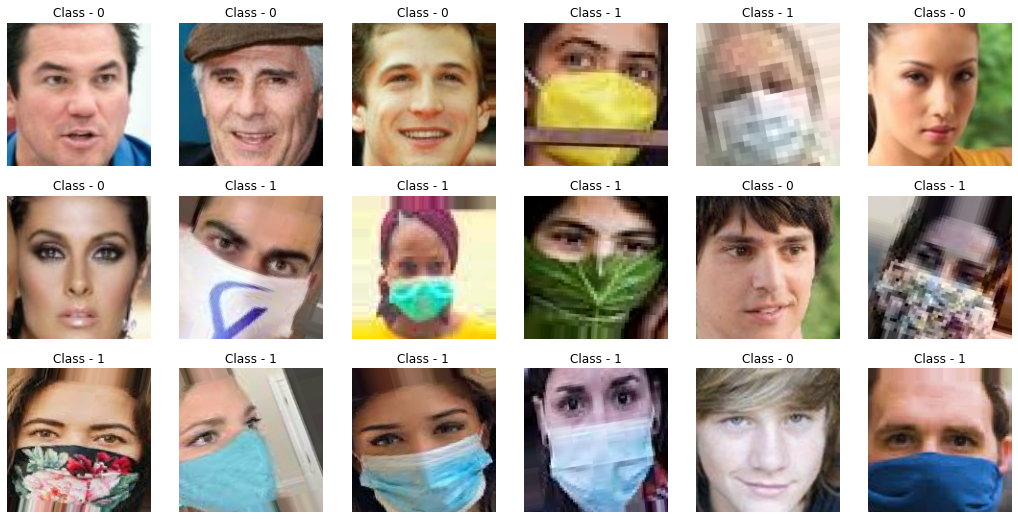

In [4]:
n_rows = 3
n_cols = 6
fig = plt.figure(figsize=(n_cols*3, n_rows*3))
    
for batch_img, batch_label in train_ds.take(1):
    for i in range(1, n_rows*n_cols+1): 
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(batch_img[i].numpy().astype("uint8"))
        plt.title("Class - " + str(batch_label[i].numpy()))
        ax.set_axis_off()

# Baseline Model

In [5]:
img_size = IMAGE_SIZE.copy()
img_size.append(3)
img_size = tuple(img_size)

baseline_model = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=img_size, activation='relu'),
    keras.layers.MaxPool2D(pool_size=6, strides=3),

    # layer 2
    keras.layers.Conv2D(filters=64, kernel_size=4, activation='relu'),
    keras.layers.MaxPool2D(pool_size=4, strides=3),

    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),

    # layer 4
    keras.layers.Dense(units=64, activation='relu'),

    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [6]:
baseline_model.summary()
baseline_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        6176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               73856     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [7]:
history = baseline_model.fit(train_ds, epochs=30, validation_data=validation_ds)

Epoch 1/30
74/74 [==============================] - 19s 244ms/step - loss: 12.5126 - binary_accuracy: 0.5569 - precision: 0.5316 - recall: 0.8120 - val_loss: 0.5406 - val_binary_accuracy: 0.7276 - val_precision: 0.6794 - val_recall: 0.8760
Epoch 2/30
74/74 [==============================] - 17s 223ms/step - loss: 0.5104 - binary_accuracy: 0.7918 - precision: 0.7680 - recall: 0.8322 - val_loss: 0.3281 - val_binary_accuracy: 0.8912 - val_precision: 0.8977 - val_recall: 0.8863
Epoch 3/30
74/74 [==============================] - 17s 225ms/step - loss: 0.3081 - binary_accuracy: 0.9078 - precision: 0.9182 - recall: 0.8921 - val_loss: 0.3215 - val_binary_accuracy: 0.8970 - val_precision: 0.8618 - val_recall: 0.9525
Epoch 4/30
74/74 [==============================] - 17s 223ms/step - loss: 0.2450 - binary_accuracy: 0.9313 - precision: 0.9424 - recall: 0.9162 - val_loss: 0.2076 - val_binary_accuracy: 0.9441 - val_precision: 0.9508 - val_recall: 0.9376
Epoch 5/30
74/74 [=========================

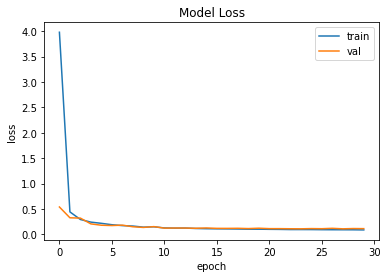

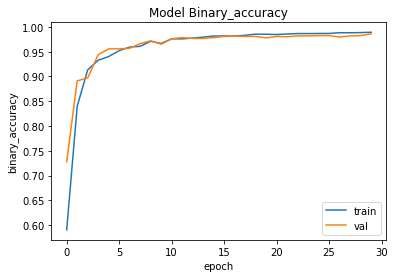

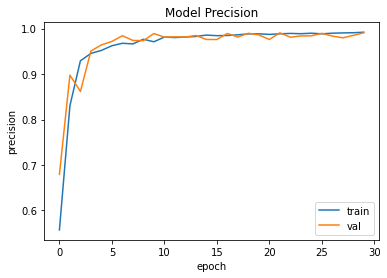

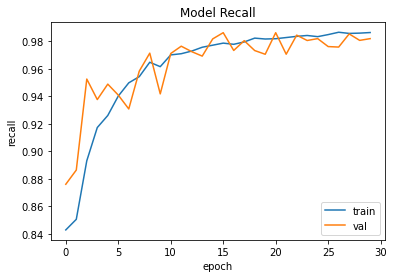

In [8]:
hist_plotter = HistoryPlotter(history=history.history)
hist_plotter.loss()
hist_plotter.metric("binary_accuracy")
hist_plotter.metric("precision")
hist_plotter.metric("recall")

In [9]:
baseline_model.evaluate(test_ds)

5/5 [==============================] - 1s 131ms/step - loss: 0.1025 - binary_accuracy: 0.9859 - precision: 0.9906 - recall: 0.9813


[0.10246336460113525,
 0.9859374761581421,
 0.9905660152435303,
 0.9813084006309509]

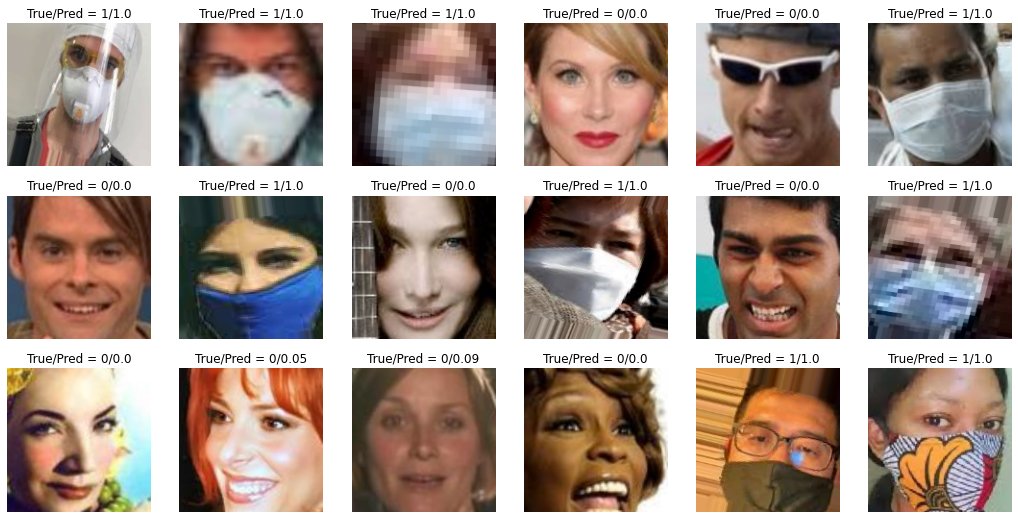

In [10]:
n_rows = 3
n_cols = 6
fig = plt.figure(figsize=(n_cols*3, n_rows*3))
    
for batch_img, batch_label in test_ds.take(1):
    batch_pred = baseline_model.predict(batch_img)
    batch_pred = np.round(batch_pred, 2)

    for i in range(1, n_rows*n_cols+1): 
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(batch_img[i].numpy().astype("uint8"))

        plt.title("True/Pred = " + str(batch_label[i].numpy()) + "/" + str(batch_pred[i][0]))
        ax.set_axis_off()
    
    